In [138]:
import json
from collections import Counter, defaultdict

# Load your JSON data here
# For the purpose of this example, I'll assume the data variable is already populated.
data = json.load(open('/home/karolwojtulewicz/code/NSVA/data/ourds_description_only.json'))

video_stat = defaultdict(list)

def analyze_data(data, output_path):
    player_counts = Counter()
    action_counts = Counter()
    plays_per_video = Counter()
    avg_players_per_action = Counter()
    action_distribution = defaultdict(set)  # Tracks in which videos each action occurs
    player_actions = defaultdict(set)  # Tracks unique actions performed by each player
    play_complexity = []  # Tracks the number of actions and players involved per play
    players_per_action = defaultdict(set)  # New: Tracks unique players involved per action
    players_per_video = defaultdict(set)  # New: Tracks unique players involved per video
    action_sequence_count = Counter()  # New: Counter for action sequences
    total_videos = len(set([item['video_id'] for item in data['sentences']]))
    
    
    # Utility function to generate all contiguous subsequences of a given sequence
    def generate_action_sequences(actions):
        sequences = []
        for length in range(2, len(actions) + 1):
            for i in range(len(actions) - length + 1):
                sequences.append(' '.join(list(actions)[i:i + length]))
        return sequences

    for item in data['sentences']:
        video_id = item['video_id']
        
        players = {key for key in item['caption'].split() if key.startswith("PLAYER")}
        actions = {action for action in item['caption'].split() if action.startswith("action")}
        if video_id not in video_stat:
            if players != {}:
                video_stat[video_id] = {
                    "players": players
                }
            elif actions != {}:
                video_stat[video_id] = {
                    "actions": actions
                }
        else:
            if video_stat[video_id].get("players") is None and players != {}:
                video_stat[video_id]["players"] = players
            elif video_stat[video_id].get("actions") is None and actions != {}:
                video_stat[video_id]["actions"] = actions
        
        if video_stat[video_id].get("players") is None or video_stat[video_id].get("actions") is None:
            continue
        else:
            players = video_stat[video_id].get("players")
            actions = video_stat[video_id].get("actions")
            
        player_counts.update(players)
        action_counts.update(actions)
        plays_per_video[video_id] = len(actions)
        play_complexity.append(len(players) + len(actions))
        
        # Generate and count action sequences for the current set of actions
        for sequence in generate_action_sequences(actions):
            action_sequence_count[sequence] += 1
        
        for action in actions:
            action_distribution[action].add(video_id)
        
        for player in players:
            player_actions[player].update(actions)
        
        for action in actions:
            action_distribution[action].add(video_id)
            players_per_action[action].update(players)  # Update players involved for each action
        
        for player in players:
            player_actions[player].update(actions)
            players_per_video[video_id].add(player)  # Update players involved in each video
        
        for action in actions:
            avg_players_per_action[action] += len(players)/len(actions)  # Update average players per action
    
    for action in avg_players_per_action:
        avg_players_per_action[action] /= len(action_distribution[action])
    total_players = len(list(set(player_counts)))
    average_actions_per_player = sum(action_counts.values()) / total_players if total_players > 0 else 0
    average_plays_per_video = sum(plays_per_video.values()) / total_videos
    most_common_action = action_counts.most_common(1)[0][0]
    average_occurrence_of_most_common_action_per_video = action_counts[most_common_action] / total_videos
    average_unique_actions_per_player = sum(len(actions) for actions in player_actions.values()) / total_players if total_players > 0 else 0
    average_play_complexity = sum(play_complexity) / len(play_complexity)
    most_involved_player = player_counts.most_common(1)[0][0]
    # Additional stats for players per action and per video
    avg_players_per_video = {video: len(players) for video, players in players_per_video.items()}

    stats = {
        "total_unique_players": total_players,
        "average_actions_per_player": average_actions_per_player,
        "average_plays_per_video": average_plays_per_video,
        "most_common_action": most_common_action,
        "average_occurrence_of_most_common_action_per_video": average_occurrence_of_most_common_action_per_video,
        "average_unique_actions_per_player": average_unique_actions_per_player,
        "average_play_complexity": average_play_complexity,
        "most_involved_player": most_involved_player,
        "action_distribution_across_videos": {action: len(videos) for action, videos in action_distribution.items()},
        "average_players_per_action": dict(avg_players_per_action),
        "average_players_per_video": dict(avg_players_per_video),
        "action_sequence_count": dict(action_sequence_count),  # Include action sequence counts
    }
    # Adjusting the calculation for players_per_action
    players_per_action = defaultdict(float)  # Change to float for average calculation

    # Save the stats to the specified output file
    with open(output_path, 'w') as file:
        json.dump(stats, file, indent=4)
    
    # with open('/home/karolwojtulewicz/code/NSVA/data/video_stat.json', 'w') as file:
    #     json.dump(video_stat, file, indent=4)

# Define your output path here
output_path = '/home/karolwojtulewicz/code/NSVA/data/data_stats.json'

# Run the analysis and save the stats
analyze_data(data, output_path)




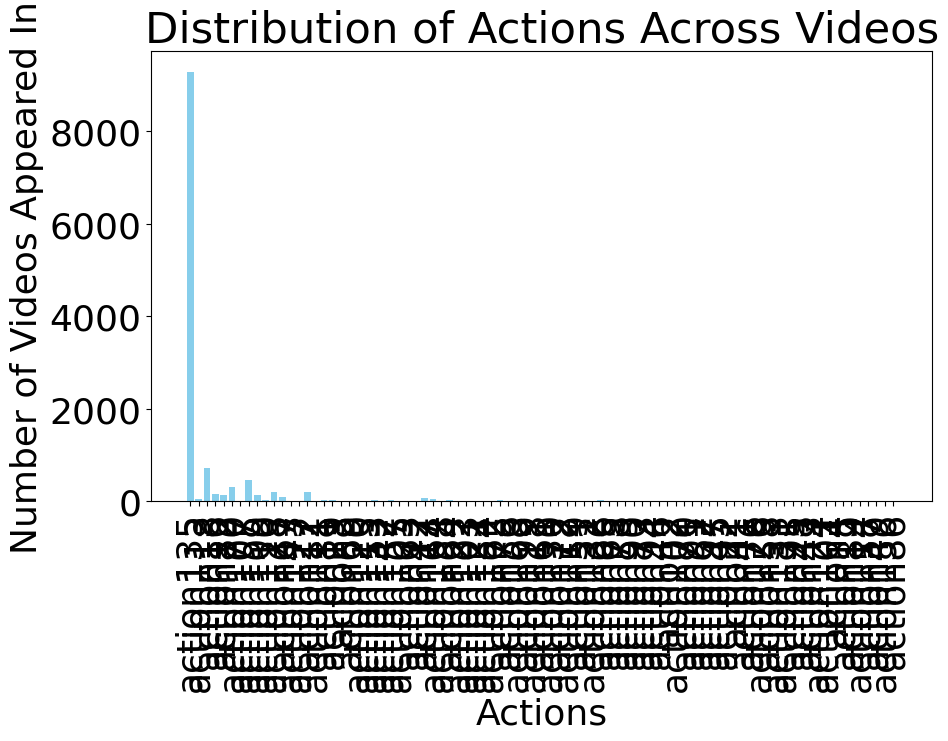

In [139]:
import matplotlib.pyplot as plt
import json

# Load the statistics from the saved file
with open('/home/karolwojtulewicz/code/NSVA/data/data_stats.json', 'r') as file:
    stats = json.load(file)

# Action distribution across videos
actions = list(stats['action_distribution_across_videos'].keys())
frequencies = list(stats['action_distribution_across_videos'].values())

plt.figure(figsize=(10, 8))
plt.bar(actions, frequencies, color='skyblue')
plt.xlabel('Actions')
plt.ylabel('Number of Videos Appeared In')
plt.title('Distribution of Actions Across Videos')
plt.xticks(rotation=90)  # Rotate action labels to avoid overlap
plt.tight_layout()  # Adjust layout to make room for the rotated x-axis labels
plt.show()

# Since the actions might be numerous, and their names could be long or not very informative as labels,
# consider summarizing or grouping actions if there are too many unique actions to display clearly.


/tmp/ipykernel_123897/3587002149.py:17: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()  # Adjust layout to make room for the rotated x-axis labels


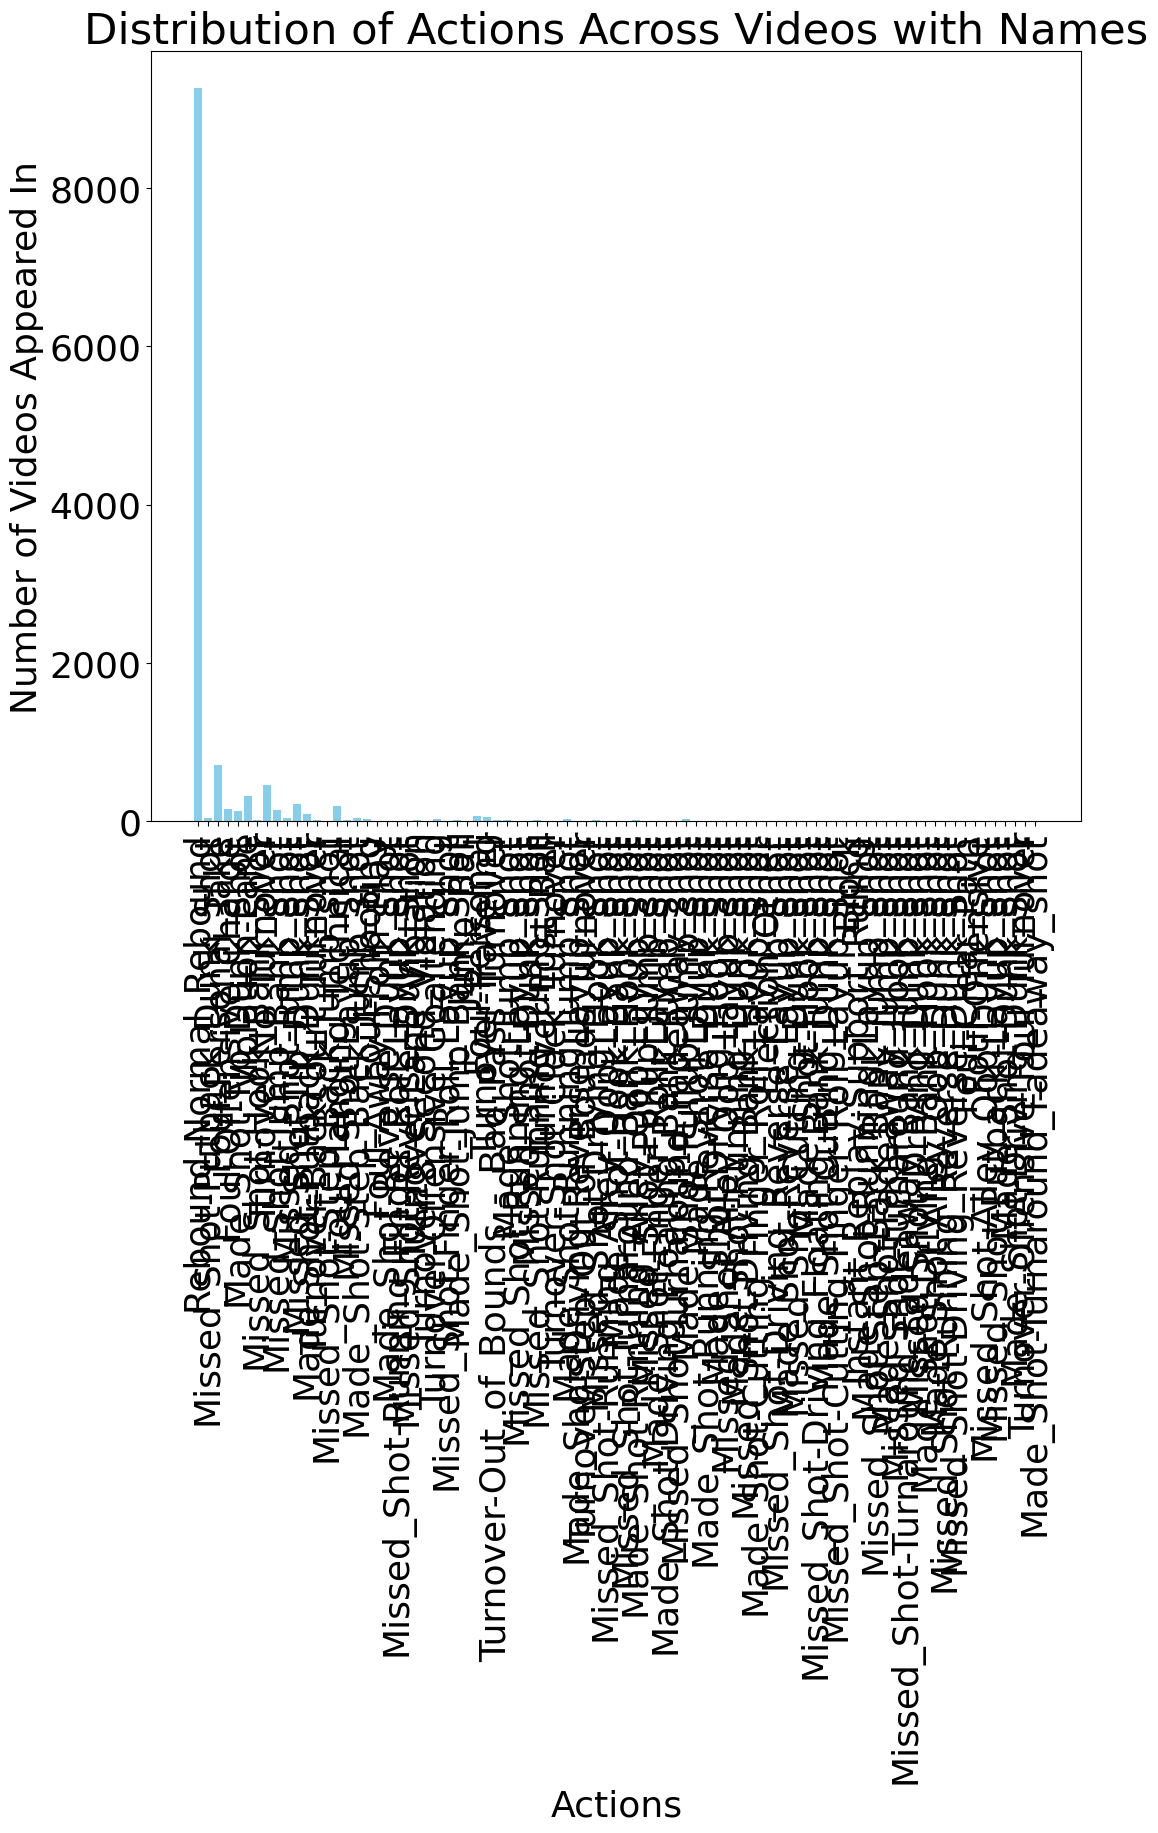

In [140]:
# Load action names from a JSON file
with open('/home/karolwojtulewicz/code/NSVA/data/action_list.json', 'r') as file:
    action_names = json.load(file)

# Create a mapping from action numbers to names
action_number_to_name = {f"action{i}": name for i, name in enumerate(action_names, start=1)}


actions_with_names = [action_number_to_name.get(action, action) for action in actions]

plt.figure(figsize=(12, 10))
plt.bar(actions_with_names, frequencies, color='skyblue')
plt.xlabel('Actions')
plt.ylabel('Number of Videos Appeared In')
plt.title('Distribution of Actions Across Videos with Names')
plt.xticks(rotation=90)  # Rotate action labels to avoid overlap
plt.tight_layout()  # Adjust layout to make room for the rotated x-axis labels
plt.show()

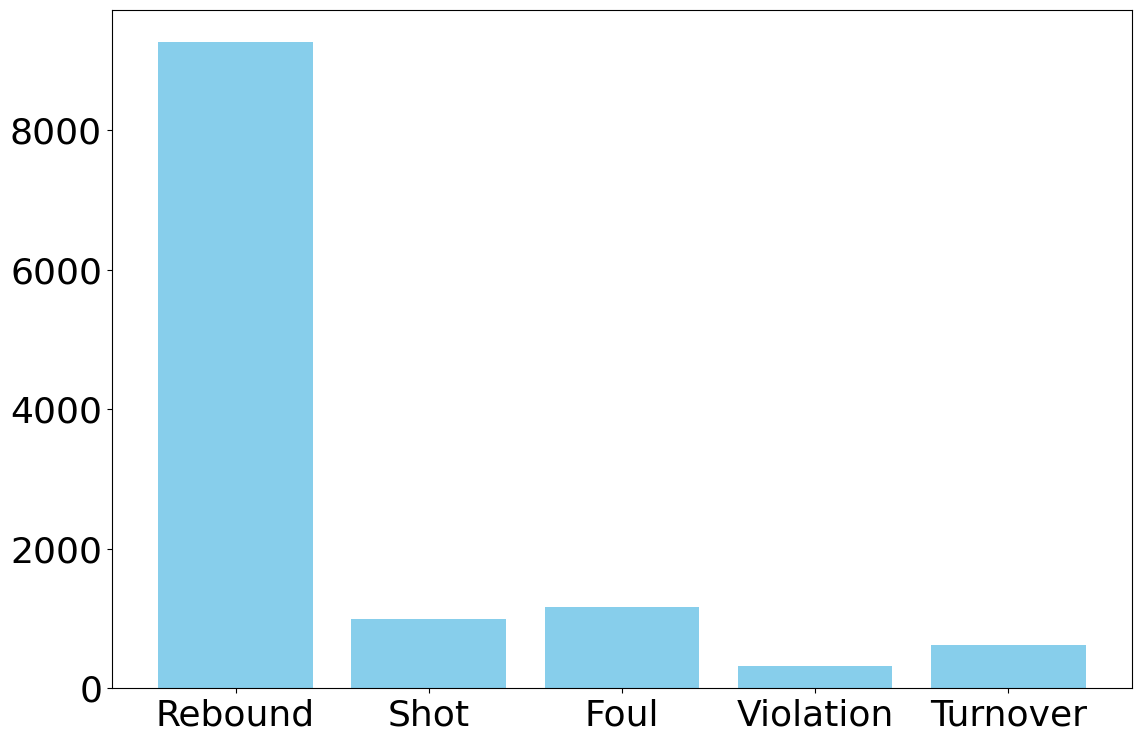

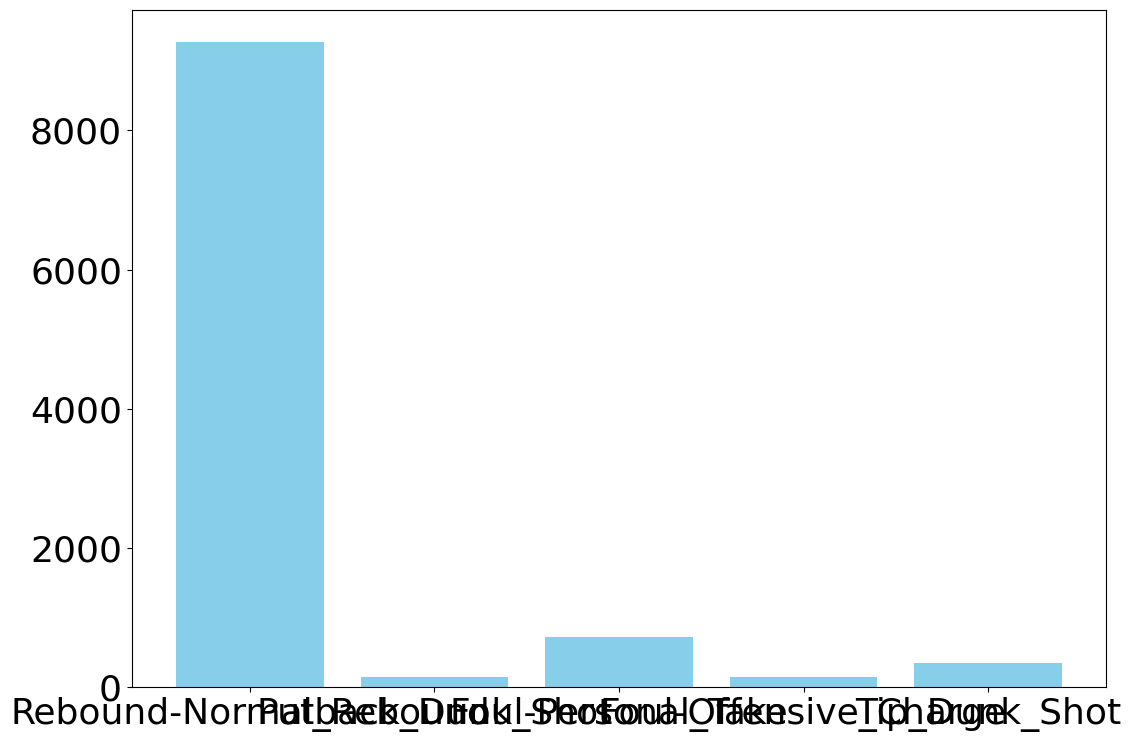

In [141]:
import matplotlib.pyplot as plt
import json

# Load the action distribution data
# This should be replaced with your actual action distribution data loading mechanism
# frequencies = list(stats['action_distribution_across_videos'].values())
action_distribution_across_videos = stats['action_distribution_across_videos']

font_size = 26
plt.rcParams.update({'font.size': font_size})

# Load the mapping files for Coarse and Fine categorizations
with open('/home/karolwojtulewicz/code/NSVA/data/action_list_Coarse.json', 'r') as file:
    action_list_coarse = json.load(file)
with open('/home/karolwojtulewicz/code/NSVA/data/action_list_Fine.json', 'r') as file:
    action_list_fine = json.load(file)

# Aggregate actions according to the provided mapping
def aggregate_actions(action_distribution, action_mapping):
    aggregated_counts = {}
    for action, count in action_distribution.items():
        group = action_mapping.get(action_number_to_name[action], 'Other')
        aggregated_counts[group] = aggregated_counts.get(group, 0) + count
    return aggregated_counts

# Aggregating actions for Coarse and Fine mappings
aggregated_coarse = aggregate_actions(action_distribution_across_videos, action_list_coarse)
aggregated_fine = aggregate_actions(action_distribution_across_videos, action_list_fine)

# Function to plot the aggregated data
def plot_aggregated_data(aggregated_data, title):
    categories = list(aggregated_data.keys())[:5]
    counts = list(aggregated_data.values())[:5]

    plt.figure(figsize=(12, 8))
    plt.bar(categories, counts, color='skyblue')
    plt.xlabel('')
    plt.ylabel('')
    plt.tight_layout()
    plt.show()

# Plotting the aggregated data for Coarse and Fine groupings
plot_aggregated_data(aggregated_coarse, 'Coarse Grouped Actions Distribution')
plot_aggregated_data(aggregated_fine, 'Fine Grouped Actions Distribution')


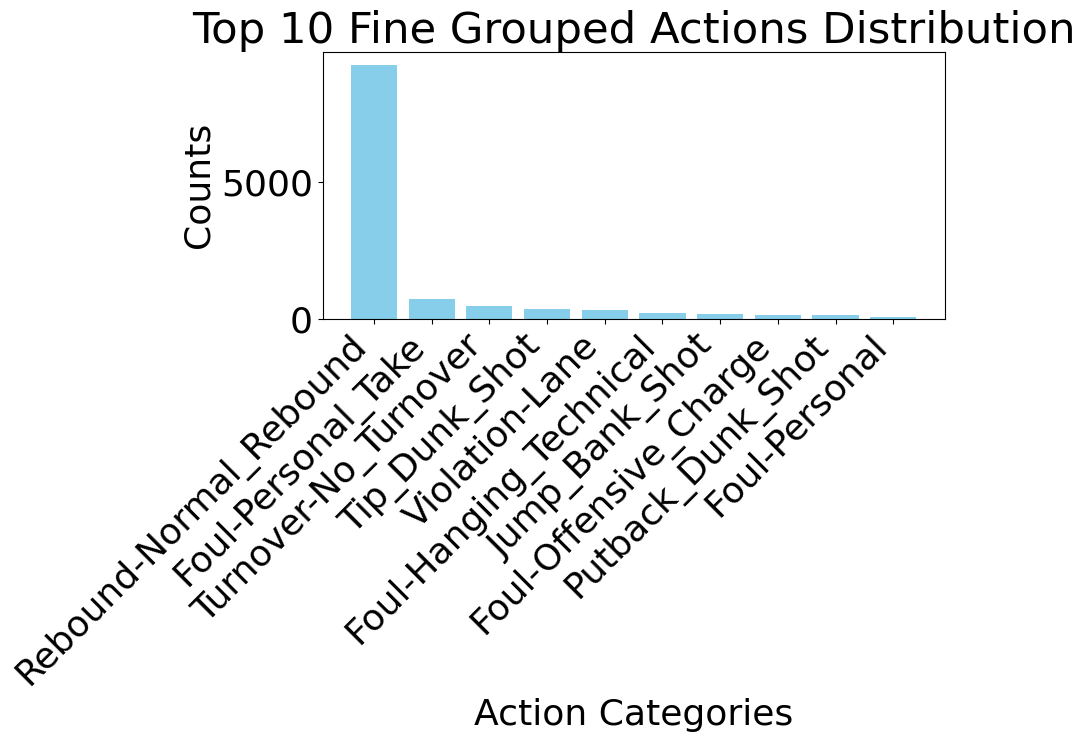

In [142]:
def plot_top_actions(aggregated_data, title, top_n=10):
    # Sort the actions based on counts and select the top N
    sorted_actions = sorted(aggregated_data.items(), key=lambda x: x[1], reverse=True)[:top_n]
    categories, counts = zip(*sorted_actions)  # Unzip into two lists

    plt.figure(figsize=(10, 8))
    plt.bar(categories, counts, color='skyblue')
    plt.xlabel('Action Categories')
    plt.ylabel('Counts')
    plt.title(f'Top {top_n} {title}')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

# Assuming aggregated_fine contains the fine group data
# Call the function with the aggregated fine data
plot_top_actions(aggregated_fine, 'Fine Grouped Actions Distribution')


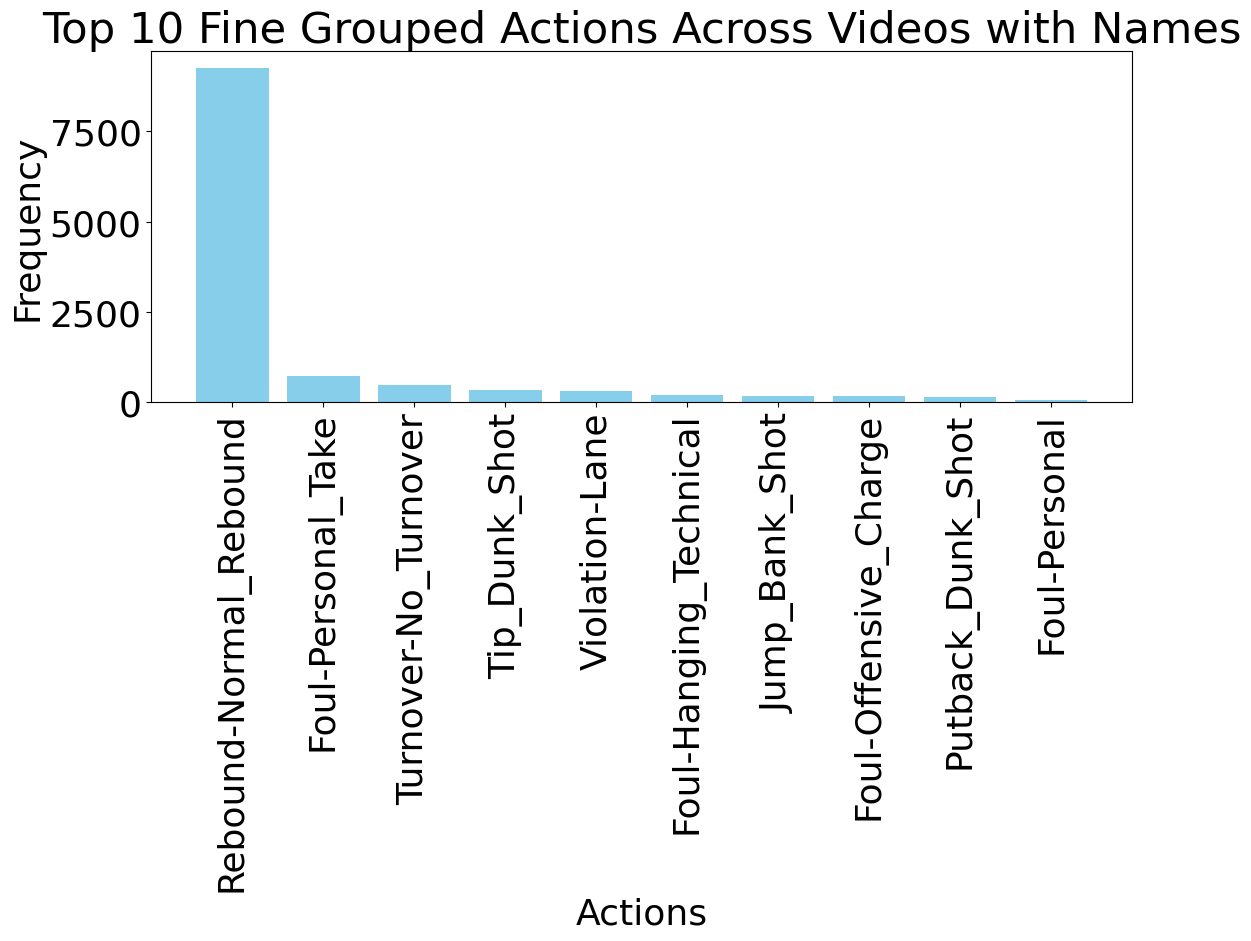

In [143]:
# Assuming 'aggregated_fine' is already defined and contains the fine grouping data
# And 'action_number_to_name' is your mapping from action numbers to names

# Sort the fine actions based on counts and get the top 10
top_10_fine_actions = sorted(aggregated_fine.items(), key=lambda x: x[1], reverse=True)[:10]
actions, frequencies = zip(*top_10_fine_actions)  # Unzip into actions and frequencies

# Map action numbers to names
actions_with_names = [action_number_to_name.get(action, action) for action in actions]

# Plot
plt.figure(figsize=(12, 10))
plt.bar(actions_with_names, frequencies, color='skyblue')
plt.xlabel('Actions')
plt.ylabel('Frequency')
plt.title('Top 10 Fine Grouped Actions Across Videos with Names')
plt.xticks(rotation=90)  # Rotate action labels to avoid overlap
plt.tight_layout()  # Adjust layout to make room for the rotated x-axis labels
plt.show()


/tmp/ipykernel_123897/3211215692.py:35: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()  # Adjust layout to make room for the labels


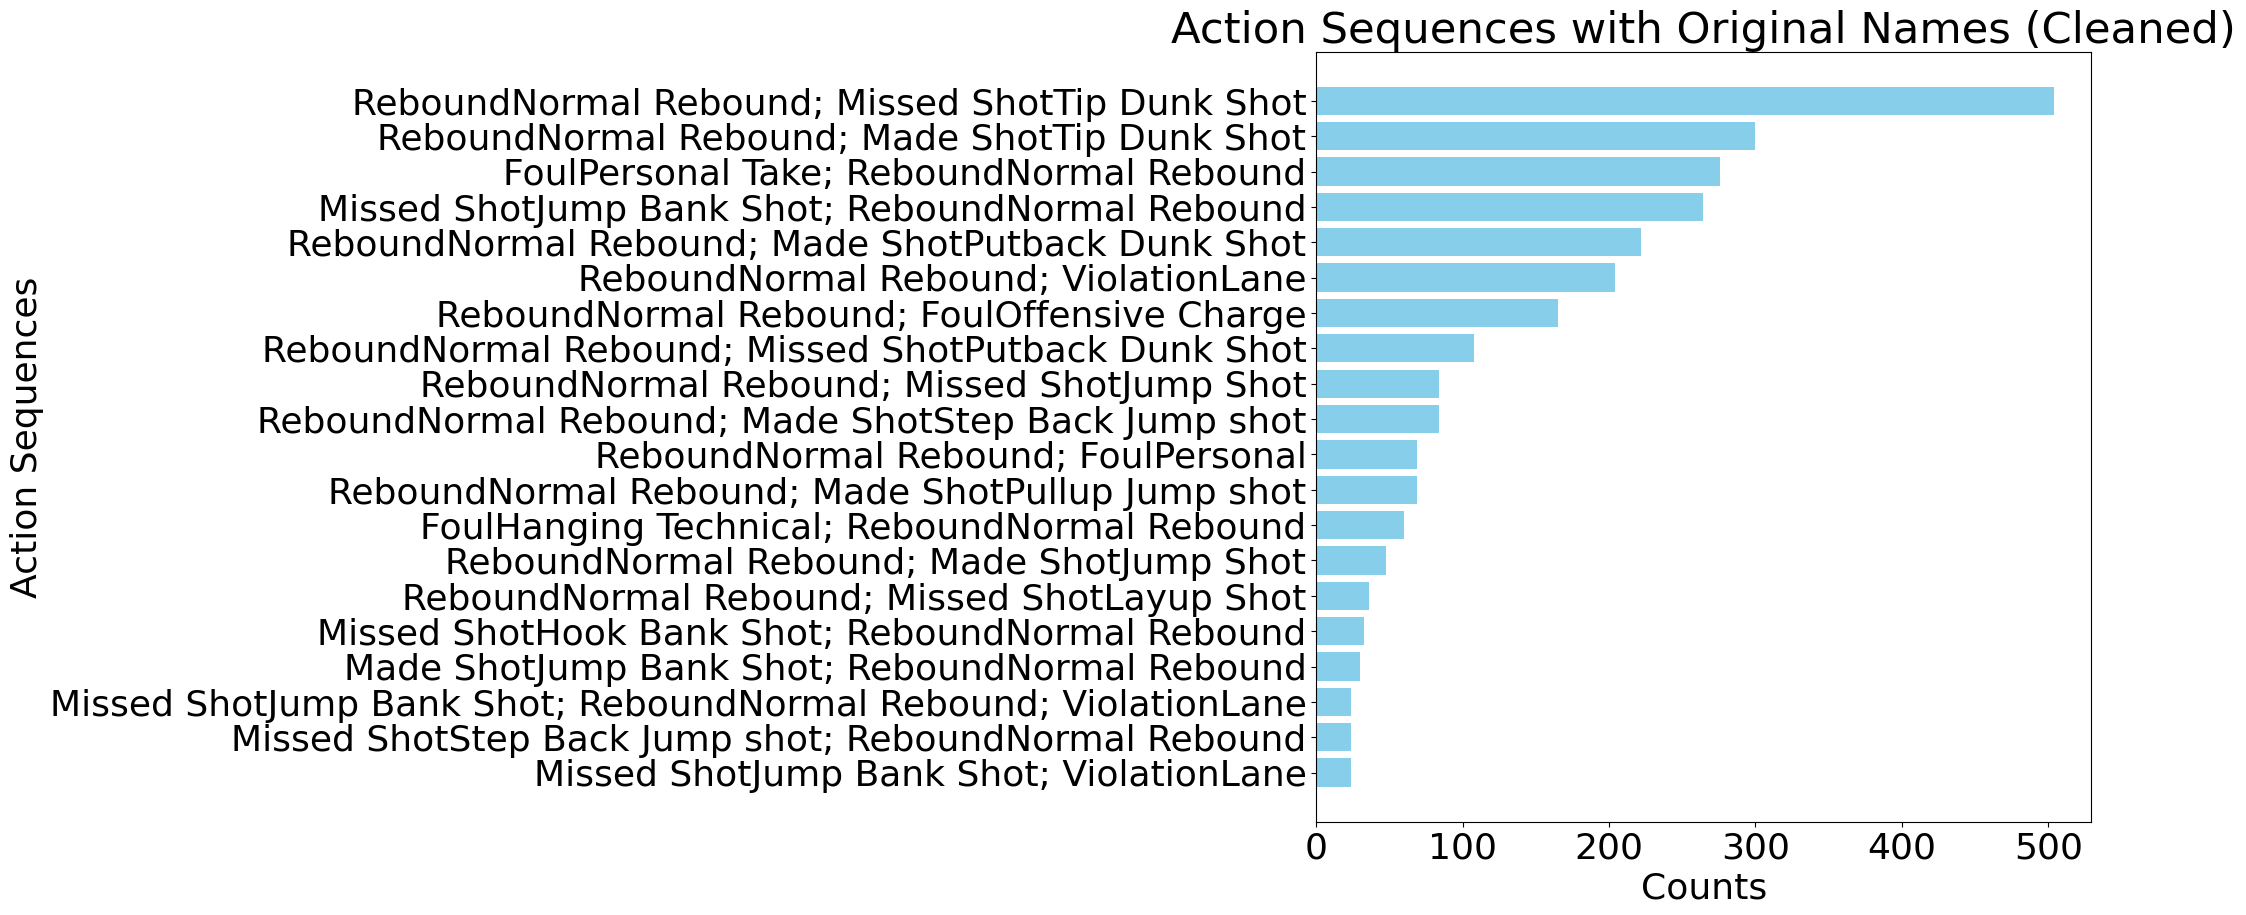

In [144]:
import json
import matplotlib.pyplot as plt

# Replace 'output.json' with the actual path to your JSON file
output_path = '/home/karolwojtulewicz/code/NSVA/data/data_stats.json'

# Load the JSON data
with open(output_path, 'r') as file:
    data = json.load(file)

# Extract the action sequence count data
action_sequence_count = data['action_sequence_count']

# Convert action numbers to names in the sequences and clean up the names
updated_action_sequence_count = {}
for sequence, count in action_sequence_count.items():
    # Split the sequence into individual actions, convert them, clean them, and rejoin
    converted_sequence = '; '.join([action_number_to_name.get(action, action).replace('-', '').replace('_', ' ') for action in sequence.split()])
    updated_action_sequence_count[converted_sequence] = count

# Sort action sequences by count, descending
sorted_action_sequences = sorted(updated_action_sequence_count.items(), key=lambda x: x[1], reverse=True)

# Extract sequences and counts for plotting
sorted_action_sequences = sorted_action_sequences[:20]  # Select the top 10 sequences
sequences, counts = zip(*sorted_action_sequences)  # Unpacking the sequences and their counts

# Plotting all sequences
plt.figure(figsize=(10, len(sequences) * 0.5))  # Adjust figure size based on the number of sequences
plt.barh(sequences, counts, color='skyblue')
plt.xlabel('Counts')
plt.ylabel('Action Sequences')
plt.title('Action Sequences with Original Names (Cleaned)')
plt.gca().invert_yaxis()  # Invert y-axis to have the sequence with the highest count at the top
plt.tight_layout()  # Adjust layout to make room for the labels
plt.show()


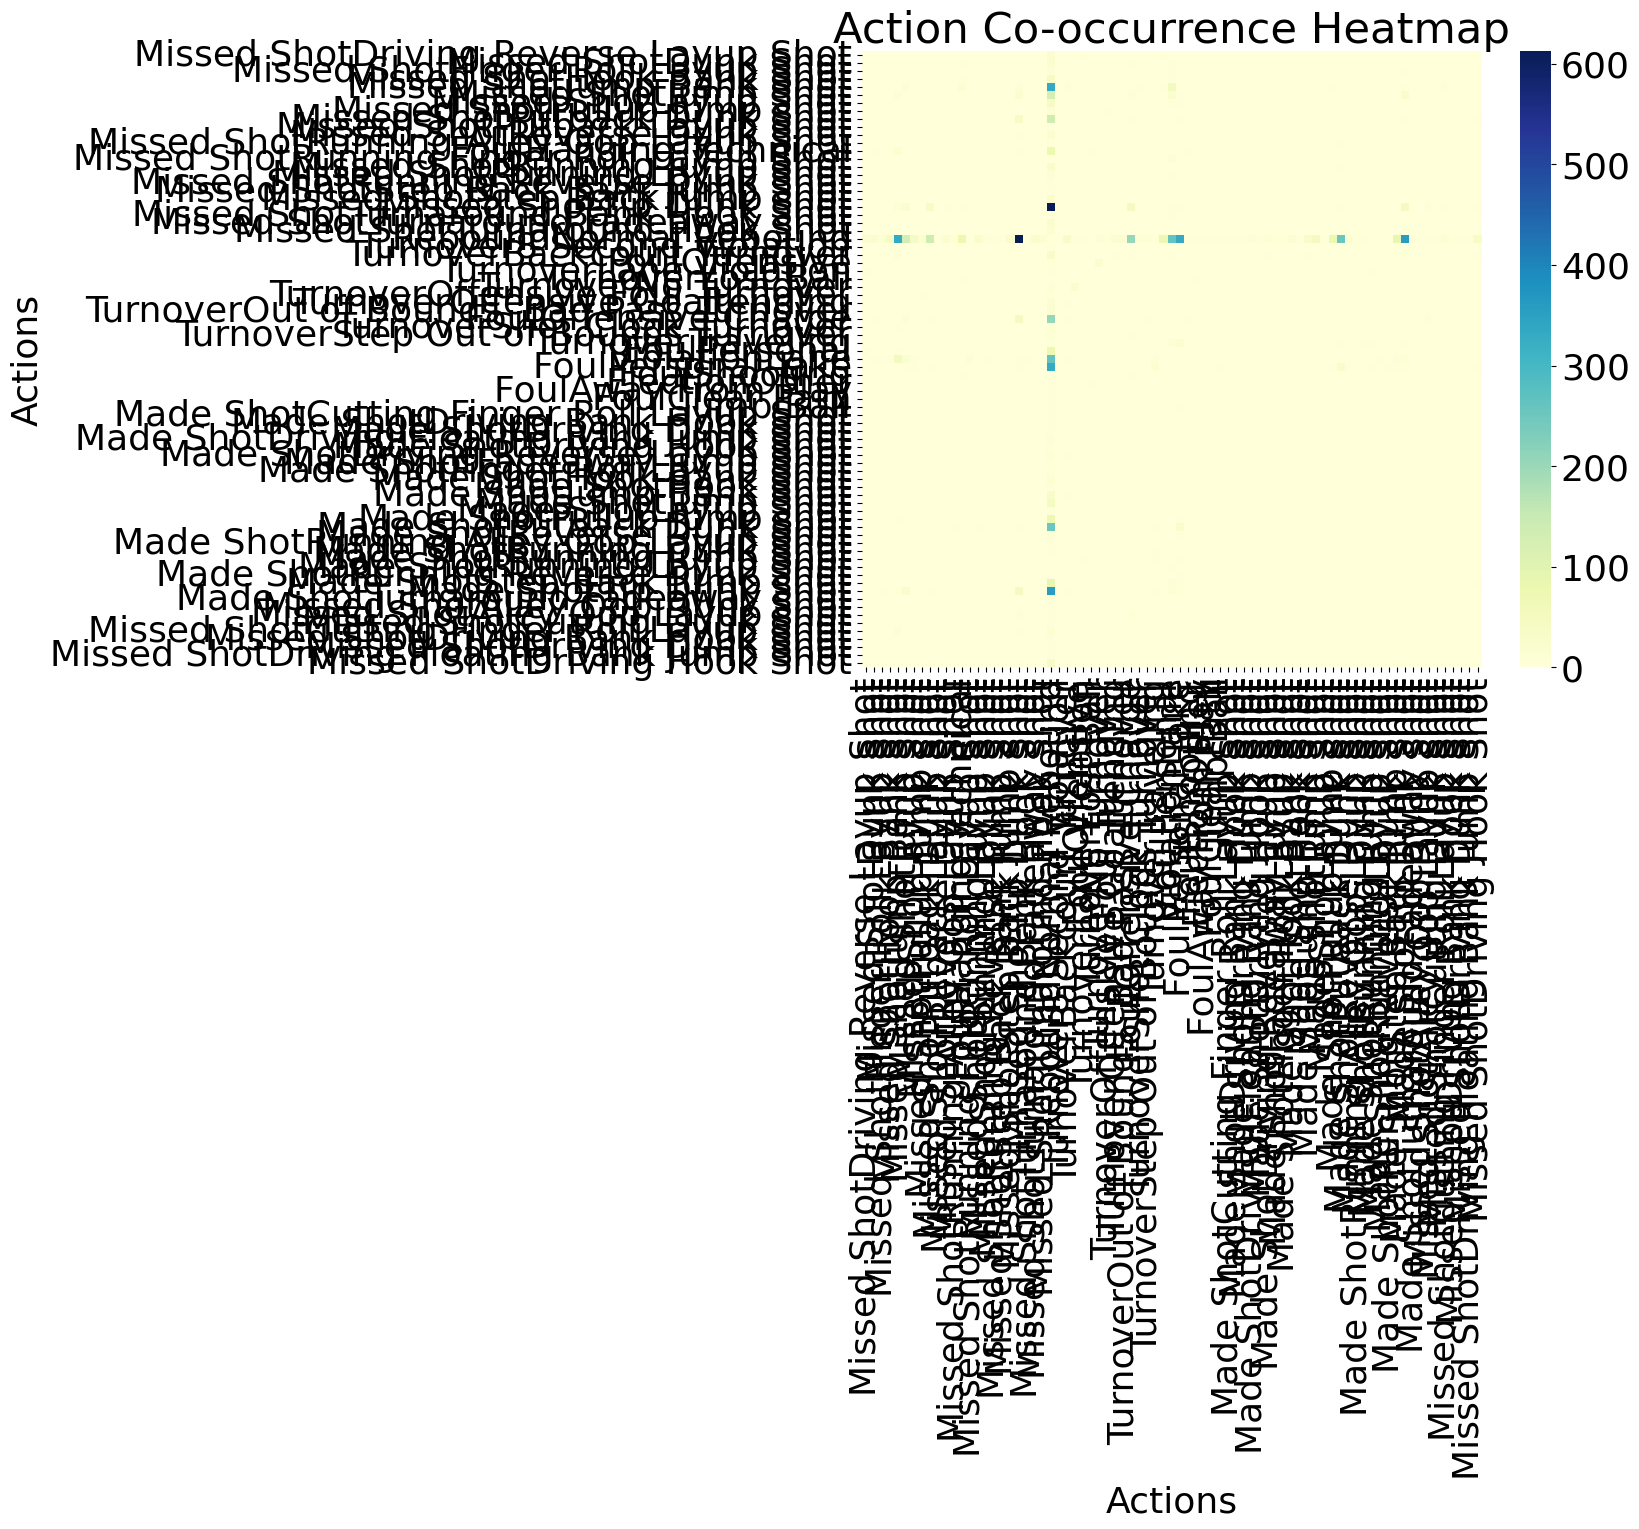

In [145]:
import numpy as np
import seaborn as sns

# Assuming action_sequence_count has been generated as before
# Generate co-occurrence data
co_occurrence = defaultdict(lambda: defaultdict(int))

# Generate co-occurrence data, focusing on sequences with multiple actions
co_occurrence = defaultdict(lambda: defaultdict(int))
for sequence, count in action_sequence_count.items():
    actions = sequence.split()  # Assuming actions are separated by spaces
    if len(actions) > 1:  # Ensure we're only considering sequences implying co-occurrences
        for action1 in actions:
            for action2 in actions:
                if action1 != action2:
                    co_occurrence[action1][action2] += count

# Filter actions that co-occur with at least one other action
filtered_actions = {action for action in co_occurrence if any(co_occurrence[action].values())}

# Convert co-occurrence data to a matrix for the heatmap
actions_list = sorted(filtered_actions)  # Sort to ensure consistent order
matrix_size = len(actions_list)
co_occurrence_matrix = np.zeros((matrix_size, matrix_size))

action_index = {action: index for index, action in enumerate(actions_list)}
for action1 in filtered_actions:
    for action2, count in co_occurrence[action1].items():
        if action1 in action_index and action2 in action_index:  # Ensure both actions are in our filtered list
            i, j = action_index[action1], action_index[action2]
            co_occurrence_matrix[i, j] = count


sns.color_palette("rocket_r", as_cmap=True)
# Plotting the heatmap without annotations for a cleaner look
plt.figure(figsize=(10, 8))
sns.heatmap(co_occurrence_matrix, annot=False, fmt="g", xticklabels=[action_number_to_name.get(action, action).replace('-', '').replace('_', ' ') for action in actions_list], yticklabels=[action_number_to_name.get(action, action).replace('-', '').replace('_', ' ') for action in actions_list], cmap="YlGnBu")
plt.title('Action Co-occurrence Heatmap')
plt.xlabel('Actions')
plt.ylabel('Actions')
plt.show()


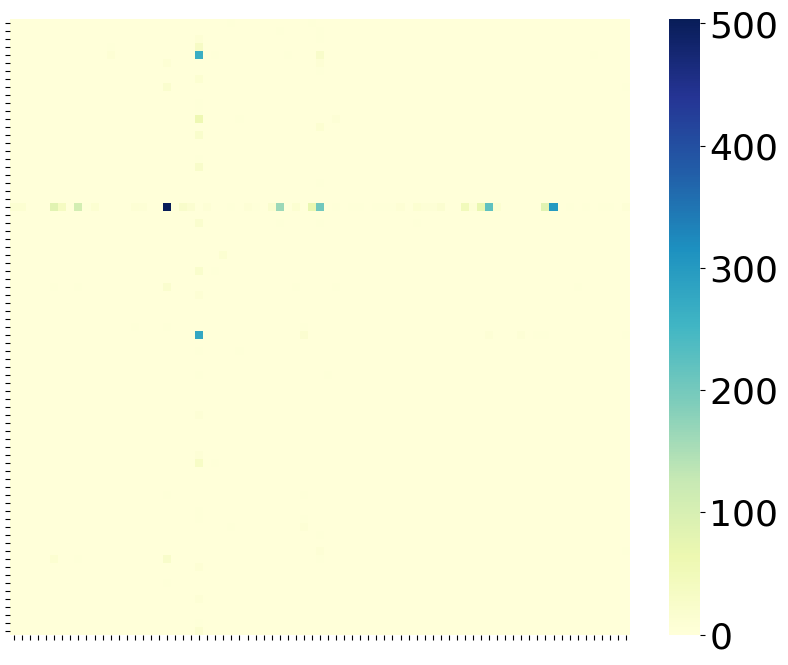

In [146]:
# Initialize co-occurrence data considering the directionality of sequences
co_occurrence = defaultdict(lambda: defaultdict(int))
# Replace 'output.json' with the actual path to your JSON file
output_path = '/home/karolwojtulewicz/code/NSVA/data/data_stats.json'

# Load the JSON data
with open(output_path, 'r') as file:
    data = json.load(file)
action_sequence_count = data['action_sequence_count']
for sequence, count in action_sequence_count.items():
    actions = sequence.split()  # Assuming actions are separated by spaces
    if len(actions) == 2:  # Focusing on pairs, respecting order
        action1, action2 = actions
        co_occurrence[action1][action2] += count

# Correctly extract unique actions involved in co-occurrences
unique_actions = set()
for action1 in co_occurrence:
    unique_actions.add(action1)
    for action2 in co_occurrence[action1]:
        unique_actions.add(action2)

# Convert co-occurrence data to a matrix for the heatmap
actions_list = sorted(list(unique_actions))  # Sort to ensure consistent order
matrix_size = len(actions_list)
co_occurrence_matrix = np.zeros((matrix_size, matrix_size))

action_index = {action: index for index, action in enumerate(actions_list)}
for action1, co_occurrences in co_occurrence.items():
    for action2, count in co_occurrences.items():
        i, j = action_index[action1], action_index[action2]
        co_occurrence_matrix[i, j] = count

# Plotting the heatmap without annotations for a cleaner look
plt.figure(figsize=(10, 8))
sns.heatmap(co_occurrence_matrix, annot=False, fmt="g", xticklabels=["" for action in actions_list], yticklabels=["" for action in actions_list], cmap="YlGnBu")

plt.xlabel('')
plt.ylabel('')
plt.show()

In [147]:
# Replace 'output.json' with the actual path to your JSON file
output_path = '/home/karolwojtulewicz/code/NSVA/data/data_stats.json'

data["isolated_actions"] = {action: action_names[action] for action, count in isolated_action_counts.items()}
# Load the JSON data
with open(output_path, 'w') as file:
    json.dump(data, file)

TypeError: list indices must be integers or slices, not str

In [ ]:
c_actions_list = {action:action_names[action] for index,action in enumerate(actions_list)}
print("Co-occuring actions {}".format(c_actions_list))

Co-occuring actions {'action102': 'Missed ShotDunk Shot', 'action103': 'Missed ShotFadeaway Jump Shot', 'action105': 'Missed ShotFloating Jump shot', 'action107': 'Missed ShotHook Shot', 'action109': 'Missed ShotJump Shot', 'action110': 'Missed ShotLayup Shot', 'action111': 'Missed ShotPullup Jump shot', 'action112': 'Missed ShotPutback Dunk Shot', 'action113': 'Missed ShotPutback Layup Shot', 'action114': 'Missed ShotReverse Dunk Shot', 'action115': 'Missed ShotReverse Layup Shot', 'action118': 'Missed ShotRunning Dunk Shot', 'action12': 'FoulLoose Ball', 'action120': 'Missed ShotRunning Jump Shot', 'action121': 'Missed ShotRunning Layup Shot', 'action122': 'Missed ShotRunning PullUp Jump Shot', 'action124': 'Missed ShotRunning Reverse Layup Shot', 'action126': 'Missed ShotStep Back Jump shot', 'action127': 'Missed ShotTip Dunk Shot', 'action128': 'Missed ShotTip Layup Shot', 'action130': 'Missed ShotTurnaround Fadeaway Bank Jump Shot', 'action132': 'Missed ShotTurnaround Hook Shot', 

## Actions that come together that do not contain a shot.

In [ ]:
cnt = 0
for value in c_actions_list.values():
    if ("Shot" not in value):
        print(value)
        cnt += 1

print(cnt)

FoulLoose Ball
ReboundUnknown
TurnoverBackcourt Turnover
TurnoverBad Pass
FoulOffensive Charge
TurnoverLost Ball
TurnoverNo Turnover
TurnoverOffensive Foul Turnover
TurnoverOffensive Goaltending
TurnoverOut of Bounds  Bad Pass Turnover
TurnoverOut of Bounds Lost Ball Turnover
FoulPersonal
TurnoverStep Out of Bounds Turnover
TurnoverTraveling
ViolationDefensive Goaltending
FoulPersonal Take
periodend
FoulShooting
FoulTechnical
FoulAway From Play
FoulClear Path
FoulDefense 3 Second
22


In [ ]:
count = 0

co_actions = {}
for action in actions_list:
    for act in actions_list:
        if co_occurrence_matrix[co_actions_list[action]][co_actions_list[act]] > 0:
            print(action, act, co_occurrence_matrix[co_actions_list[action]][co_actions_list[act]])
            count += 1
            co_actions[action + " " + act] = co_occurrence_matrix[co_actions_list[action]][co_actions_list[act]]

# update the data
data["co_occurrence_actions"] = co_actions

with open(output_path, 'w') as file:
    data = json.dump(data, file)

print(count)

action102 action153 3.0
action102 action17 3.0
action103 action16 3.0
action103 action170 3.0
action105 action135 9.0
action105 action170 3.0
action107 action12 3.0
action107 action135 33.0
action109 action12 9.0
action109 action135 264.0
action109 action143 3.0
action109 action162 3.0
action109 action170 24.0
action109 action92 3.0
action110 action128 9.0
action110 action170 9.0
action111 action170 3.0
action112 action135 12.0
action113 action128 18.0
action113 action99 3.0
action115 action135 3.0
action118 action135 3.0
action12 action135 60.0
action12 action154 3.0
action12 action19 6.0
action120 action170 12.0
action121 action135 21.0
action126 action135 3.0
action127 action135 24.0
action130 action170 3.0
action135 action102 12.0
action135 action103 12.0
action135 action110 84.0
action135 action111 36.0
action135 action113 108.0
action135 action114 3.0
action135 action115 12.0
action135 action122 9.0
action135 action124 6.0
action135 action128 504.0
action135 action130 3.0
action1